# Import packages

In [36]:
import umap
import json
import numpy as np
import matplotlib.pyplot as plt
import cv2
from time import time
from torchvision import datasets, transforms

# Load neuron embedding of the base model

In [2]:
def load_json(p):
    with open(p) as f:
        data = json.load(f)
    return data

def draw_scatter(Xs):
    X = Xs[:,0]
    Y = Xs[:,1]

    plt.figure(figsize=(4, 4))
    plt.scatter(X, Y, s=3, alpha=0.2)
    plt.show()
    
def reduce_dim(X):
    reducer = umap.UMAP(n_components=2)
    reducer = reducer.fit(X)
    return reducer.embedding_

In [3]:
p = '/raid/NeuEvo/data/embedding/emb-convnext_pretrained-topk_s=20-dim=30-lr_emb=0.01-num_emb_epochs=500-num_emb_negs=3/data/emb/emb.json'
n_emb = load_json(p)
num_neurons = len(n_emb)

In [4]:
n_X = np.zeros((num_neurons, 30))
for neuron_i, neuron in enumerate(n_emb):
    n_X[neuron_i] = n_emb[neuron]

In [5]:
n_X_2d = reduce_dim(n_X)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


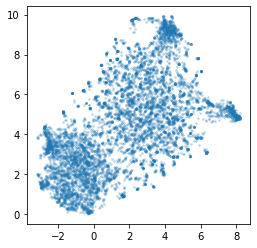

In [6]:
draw_scatter(n_X_2d)

# Load image embedding

In [7]:
def gen_avg_img_vec(imgs, i_X, dim):
    avg_v = np.zeros(dim)
    for img in imgs:
        avg_v += i_X[img]
    avg_v /= len(imgs)
    return avg_v

In [8]:
p = '/raid/NeuEvo/data/embedding/emb-convnext_pretrained-topk_s=20-dim=30-lr_emb=0.01-num_emb_epochs=500-num_emb_negs=3/data/emb-set-dim=30-lr_img_emb=0.1-thr_img_emb=0.01-max_iter_img_emb=20000-k=10/emb_nd/img_emb.txt'
i_X = np.loadtxt(p)

# Base model's projection

In [37]:
raw_data_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

raw_training_datasets = datasets.ImageFolder(
    '../../../../ILSVRC2012/train',
    raw_data_transform
)

def show_imgs(img_idxs):
    for img_idx in img_idxs:
        img = raw_training_datasets[img_idx][0]
        img = np.einsum('kij->ijk', img)
        plt.title(f'img: {img_idx}')
        plt.imshow(img)
        plt.show()
        
def show_np_imgs_2_rows(imgs, title=None, subplot_titles=None):
    # Create figure
    nrows = 2
    ncols = len(imgs) // nrows
    fig, ax = plt.subplots(nrows, ncols, figsize=(2 * ncols, 2 * nrows))
    fig.tight_layout()
    
    # Create subplots
    for i, img in enumerate(imgs[:nrows * ncols]):
        row = int(i / ncols)
        col = i - row * ncols
        ax[row, col].imshow(img) 
        ax[row, col].set_axis_off()
        if subplot_titles is not None:
            ax[row, col].set_title(subplot_titles[i])

    # Title
    if title is not None:
        fig.suptitle(title, y=1.06)
        
    # Show the final plot
    plt.show()
        
def show_imgs_2_rows(img_idxs, title=None):
    # Images
    imgs = []
    subplot_titles = []
    for i, img_idx in enumerate(img_idxs):
        img = raw_training_datasets[img_idx][0]
        img = np.einsum('kij->ijk', img)
        imgs.append(img)
        subplot_titles.append(f'{i}-th img: {img_idx}')
        
    # Show images
    show_np_imgs_2_rows(imgs, title=title, subplot_titles=subplot_titles)

In [40]:
def get_ex_patch_dir_path(model_nickname, topk_s, ex_patch_size_ratio):
    root = '/raid/NeuEvo/data/neuron_feature'
    return f'{root}/{model_nickname}/data/topk_s={topk_s}-ex_patch_size_ratio={ex_patch_size_ratio}'

def get_ex_patch_img_paths(model_nickname, topk_s, ex_patch_size_ratio, layer, neuron_idx):
    d = get_ex_patch_dir_path(model_nickname, topk_s, ex_patch_size_ratio)
    paths = []
    for i in range(topk_s):
        paths.append(f'{d}/{layer}-{neuron_idx}-{i}.jpg')
    return paths

def load_img_from_path(p):
    img = cv2.imread(p)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img
                     
def show_ex_patch(model_nickname, topk_s, ex_patch_size_ratio, layer, neuron_idx):
    img_ps = get_ex_patch_img_paths(model_nickname, topk_s, ex_patch_size_ratio, layer, neuron_idx)
    imgs = [load_img_from_path(img_path) for img_path in img_ps]
    title = f'{model_nickname}, {layer}-{neuron_idx}'
    show_np_imgs_2_rows(imgs, title=title, subplot_titles=None)

In [70]:
p = '/raid/NeuEvo/data/stimulus/convnext_pretrained/data/stimulus-topk_s=20.json'
stimulus = load_json(p)

In [71]:
vocab = {}
for layer in stimulus:
    for imgs in stimulus[layer]:
        for img in imgs:
            if img not in vocab:
                vocab[img] = 0
            vocab[img] += 1
len(vocab)

97345

In [29]:
dim = 30
idx_to_neuron_id = {}
p_X = np.zeros((num_neurons, dim))
for n, neuron_id in enumerate(n_emb):
    layer, neuron_idx = neuron_id.split('-')
    neuron_idx = int(neuron_idx)
    imgs = stimulus[layer][neuron_idx]
    p_X[n] = gen_avg_img_vec(imgs, i_X, dim)
    idx_to_neuron_id[n] = neuron_id

In [30]:
p_X_2d = reduce_dim(p_X)

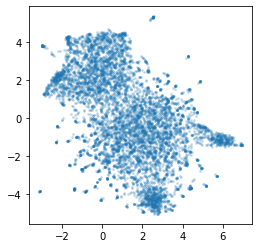

In [31]:
draw_scatter(p_X_2d)

In [32]:
p_X_2d.shape

(8640, 2)

In [68]:
Xs, Ys = p_X_2d[:,0], p_X_2d[:,1]

neurons = {}
for i, (x, y) in enumerate(zip(Xs, Ys)):
    if -4 <= x <= -2 and -4 <= y <= -2:
        neurons[idx_to_neuron_id[i]] = True

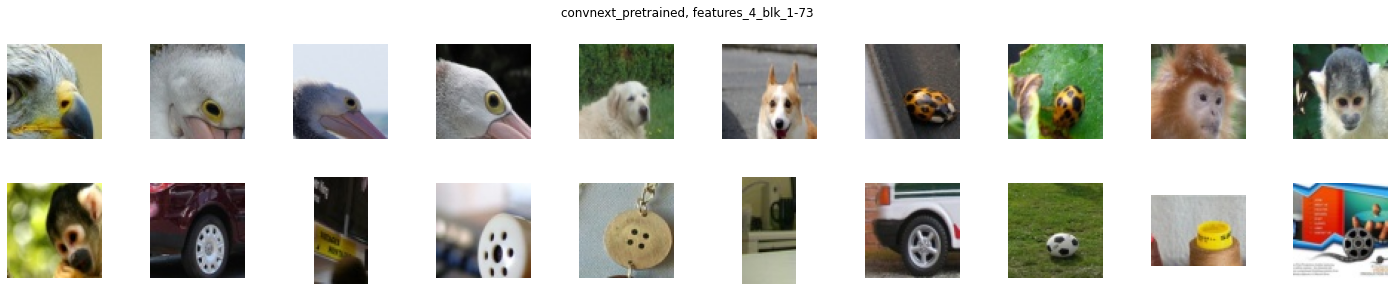

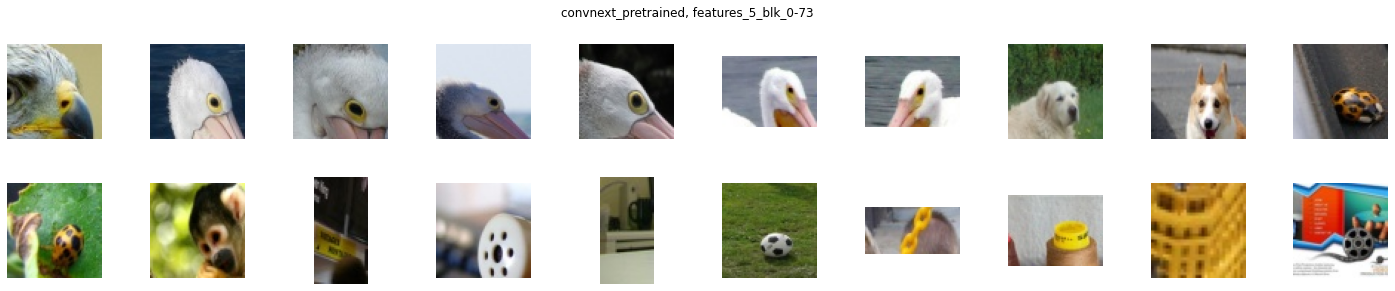

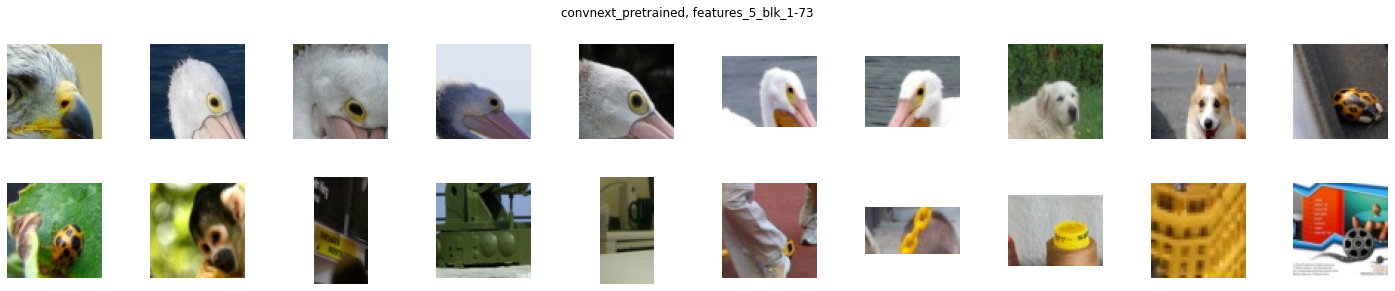

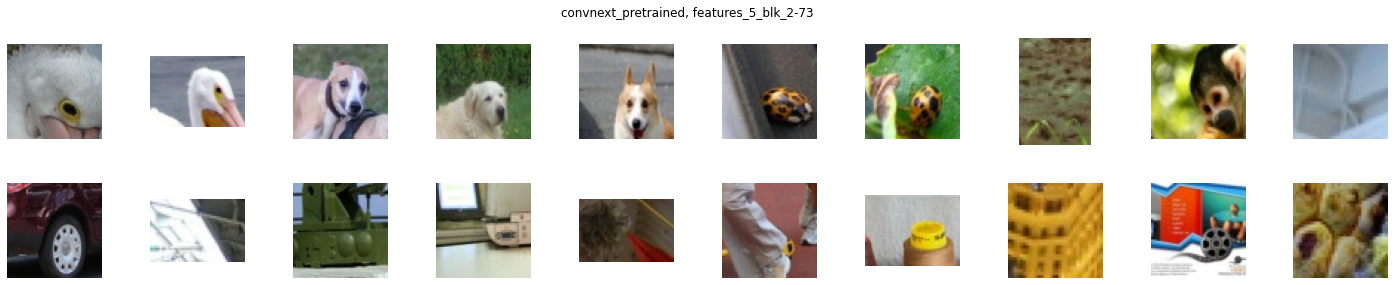

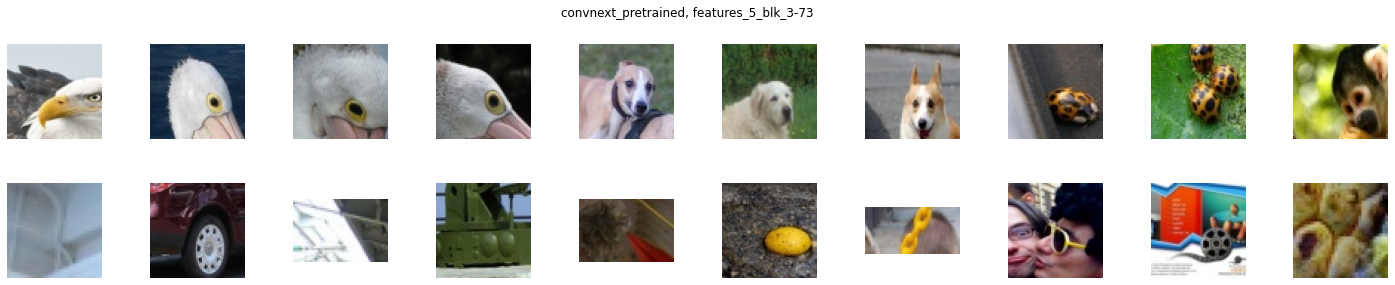

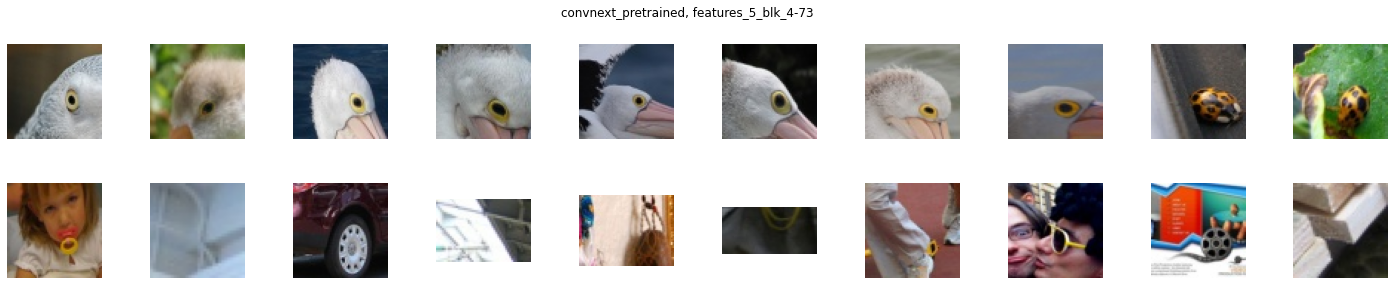

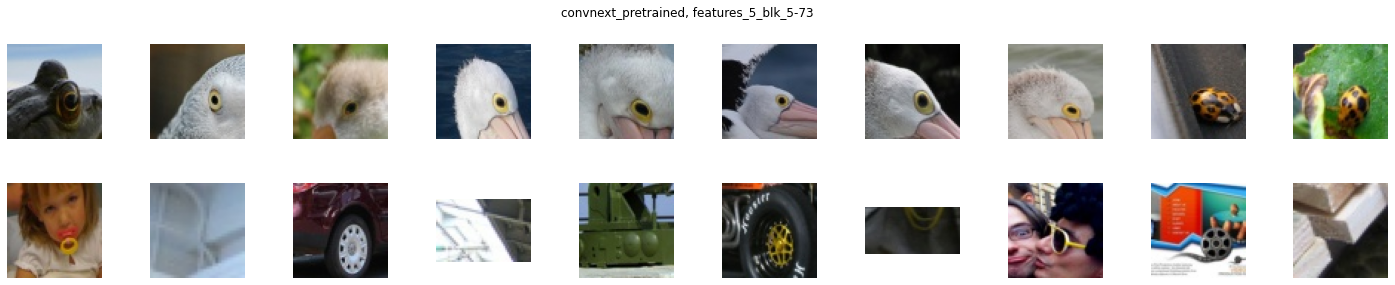

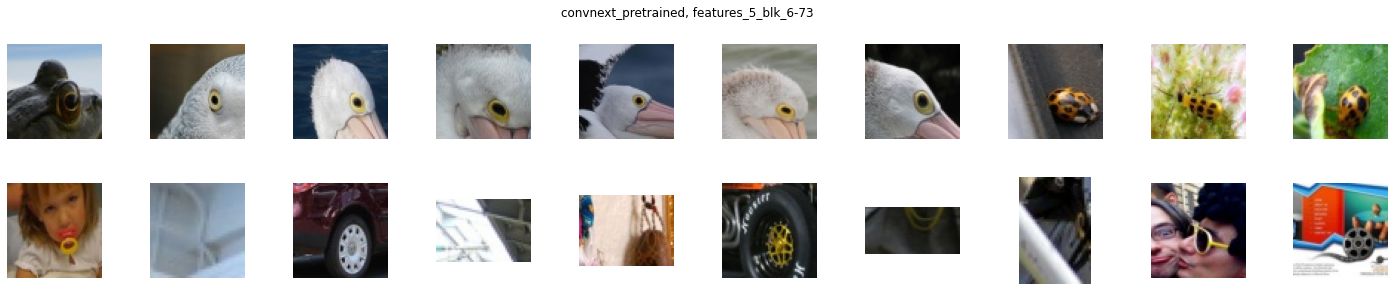

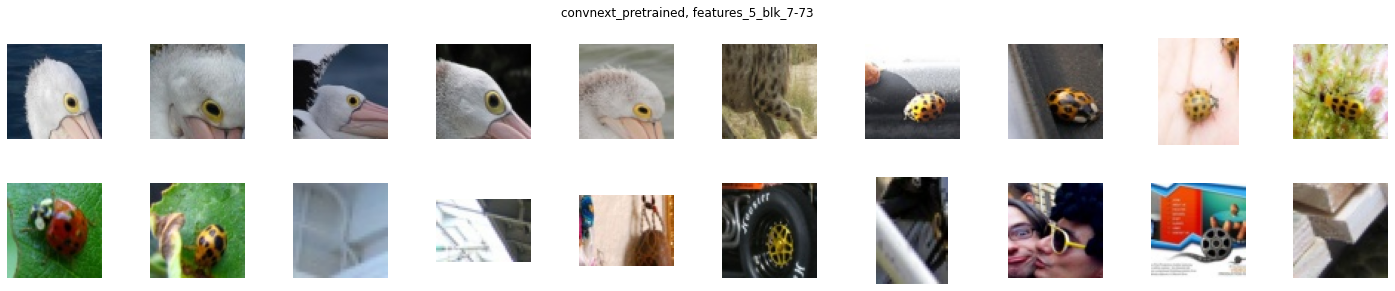

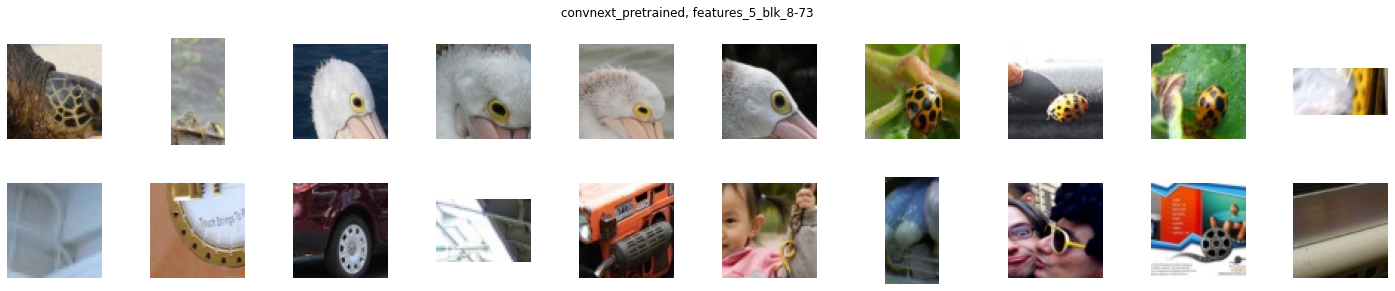

In [69]:
for neuron in list(neurons.keys())[:10]:
    layer, neuron_idx = neuron.split('-')
    neuron_idx = int(neuron_idx)
    show_ex_patch('convnext_pretrained', 20, 0.3, layer, neuron_idx)
    # show_imgs_2_rows(stimulus[layer][neuron_idx], title=neuron)

# A non-base model's projection

In [73]:
def load_stimulus(model_nickname):
    p = f'/raid/NeuEvo/data/stimulus/{model_nickname}/data/stimulus-topk_s=20.json'
    data = load_json(p)
    return data

def draw_projection(model_nickname, i_X, vocab):
    # Get stimulus
    stimulus = load_stimulus(model_nickname)
    
    # Get number of neurons
    num_neurons = 0
    for layer in stimulus:
        num_neurons += len(stimulus[layer])
        
    # Get projection vector
    dim = 30
    p_X = np.zeros((num_neurons, dim))
    n = 0
    for layer in stimulus:
        for neuron_stimuli in stimulus[layer]:
            imgs = [img for img in neuron_stimuli if img in vocab]
            if len(imgs) > 0:
                p_X[n] = gen_avg_img_vec(imgs, i_X, dim)
            n += 1
    
    # Draw 2D vectors
    p_X_2d = reduce_dim(p_X)
    draw_scatter(p_X_2d)

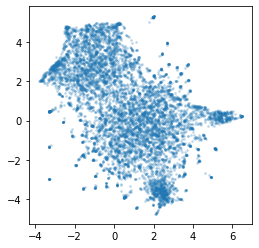

In [25]:
draw_projection('convnext_pretrained', i_X)

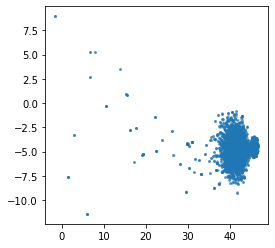

In [75]:
draw_projection('convnext_0.004_96', i_X, vocab)

In [74]:
draw_projection('convnext_0.004_96', i_X)

TypeError: draw_projection() missing 1 required positional argument: 'vocab'

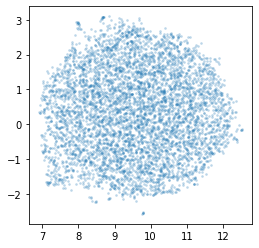

In [27]:
draw_projection('vgg19_pretrained', i_X)

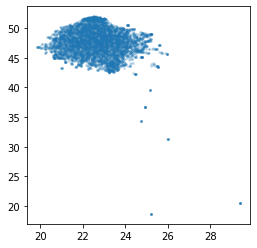

In [76]:
draw_projection('vgg19_pretrained', i_X, vocab)